Chargement du Dataset


In [1]:
import pandas as pd
df=pd.read_csv("/kaggle/input/dataentrinment/MyData.csv")
df.head()


,Class,reclean_text
0,normal,وزير طاقة خارجي لبناني جبران سيل قال سلسل تغري...
1,normal,سوريه بلد حضارة ربط بحيون
2,normal,اخي الحاج شعر محرج انتقاد تصريح جبران سيل داعي...
3,normal,فيك عاش كب فتن ليل نهار كر قل موضوع سيد
4,hate,بطل قاتل جاذف حية حي واطي عيب شوم


In [2]:
print(df['Class'].value_counts())


Class
hate      9512
normal    8699
Name: count, dtype: int64


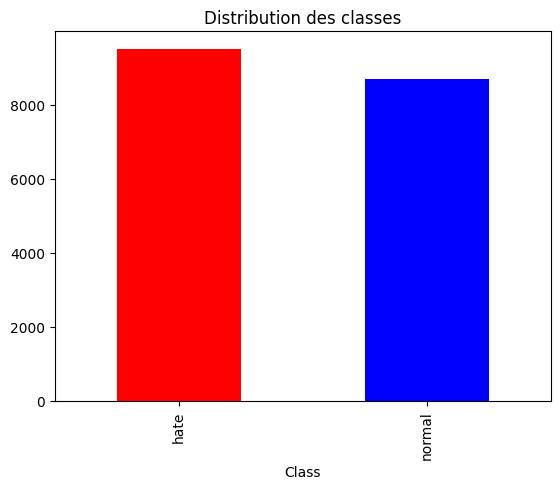

In [3]:
import matplotlib.pyplot as plt
df["Class"].value_counts().plot(kind="bar", color=["red", "blue"])
plt.title("Distribution des classes")
plt.show()

In [3]:
!pip install datasets

In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split



label_mapping = {"hate": 1, "normal": 0}


df["Class"] = df["Class"].replace("hate", 1)
df["Class"] = df["Class"].replace("normal", 0)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["reclean_text"], df["Class"], test_size=0.2, random_state=42
)

# Charger  tokenizer AraBERT
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
train_texts = train_texts.astype(str).tolist()
test_texts = test_texts.astype(str).tolist()


train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


len(train_encodings['input_ids'])

14568

In [ ]:
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


train_dataset = HateSpeechDataset(train_encodings, train_labels.tolist())
test_dataset = HateSpeechDataset(test_encodings, test_labels.tolist())
len(train_dataset)


14568

In [ ]:
from sklearn.metrics import accuracy_score
model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02", num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,      
    per_device_eval_batch_size=32,       
    num_train_epochs=5,                  
    learning_rate=2e-5,                  
    weight_decay=0.01,                   
    warmup_ratio=0.1,                    
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=50,
    report_to="none",
    seed=42
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [19]:
torch.save(model.state_dict(), 'my_model.pth')

In [21]:
import zipfile

with zipfile.ZipFile("my_model_pth.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("/kaggle/working/my_model.pth")


In [ ]:

results = trainer.evaluate()
print("✅ Résultats de l'évaluation :", results)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Résultats de l'évaluation : {'eval_loss': 0.22592292726039886, 'eval_accuracy': 0.9404337084820203, 'eval_runtime': 9.8162, 'eval_samples_per_second': 371.123, 'eval_steps_per_second': 5.807, 'epoch': 5.0}


In [ ]:
from sklearn.metrics import classification_report
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)

print(classification_report(y_true, y_pred))

In [64]:
kaggle kernels output <kernel-id> -p /Users/DELL/Desktop


Note: you may need to restart the kernel to use updated packages.


In [59]:
torch.save(model.state_dict(), 'model.pth')